In [1]:
import torch
import pickle
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from datamodule import StepOneDataset
from engine import ClassificationEngine
from xvector import XVector
from os.path import dirname
from pathlib import Path
from read import parse_config
CONFIG = parse_config()

In [42]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from tqdm.auto import tqdm
from torch.nn import functional as F
from collections import OrderedDict
from scipy.special import softmax


class ClassificationEngine(pl.LightningModule):

    def __init__(
            self, 
            backbone, 
            learning_rate=1e-4, 
            weight_decay=0.0005
        ):
        super().__init__()
        self.save_hyperparameters()
        self.backbone = backbone

        # Save the logs to visualise
        self.train_losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []

    def forward(self, x):
        logits = self.backbone(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y.long())
        acc = (logits.argmax(-1) == y).float()
        return {'loss': loss, 'acc': acc, 'log': {'train_loss': loss}}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        train_acc = torch.stack([x['acc'] for x in outputs]).mean()
        self.train_losses.append(avg_loss.detach().cpu().item())
        self.train_accuracies.append(train_acc.detach().cpu().item())
        torch.cuda.empty_cache()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y.long())
        acc = (logits.argmax(-1) == y).float()
        return {'loss': loss, 'acc': acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        val_acc = torch.stack([x['acc'] for x in outputs]).mean()
        out = {'val_loss': avg_loss, 'val_acc': val_acc}
        self.valid_losses.append(avg_loss.detach().cpu().item())
        self.valid_accuracies.append(val_acc.detach().cpu().item())
        torch.cuda.empty_cache()
        return {**out, 'log': out}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), 
            betas=(0.95, 0.999), 
            lr=self.hparams.learning_rate, 
            weight_decay=self.hparams.weight_decay
        )

    def predict_proba(self, test_dl):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.eval()
        self.to(device)
        y_probs = []
        with torch.no_grad():
            for _, batch in enumerate(tqdm(test_dl), 0):
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = self(inputs)
                y_probs.extend(outputs.detach().cpu().numpy())
        return softmax(np.vstack(y_probs), axis=1)

    def predict(self, test_dl):
        y_prob = self.predict_proba(test_dl)
        y_pred = np.argmax(y_prob, axis=1)
        return y_pred

    def plot(self):
        plt.figure(figsize=(15, 6))
        plt.subplot(2, 1, 1)
        plt.plot(range(len(self.train_losses)), self.train_losses, label="train")
        plt.plot(range(len(self.valid_losses)), self.valid_losses, label="valid")
        plt.title("Loss")
        plt.legend(loc="upper right")
        plt.grid()
        plt.subplot(2, 1, 2)
        plt.plot(range(len(self.train_accuracies)), self.train_accuracies, label="train")
        plt.plot(range(len(self.valid_accuracies)), self.valid_accuracies, label="valid")
        plt.title("Accuracy")
        plt.legend(loc="upper right")
        plt.grid()
        plt.tight_layout()
        plt.show()

In [33]:
trn_seg = CONFIG['train_segments']
tst_seg = CONFIG['test_segments']
path = f'../data/trn{trn_seg}_tst{tst_seg}.pkl'
train_valid_ds = StepOneDataset(path, CONFIG, state='train')
test_ds = StepOneDataset(path, CONFIG, state='test')
train_ds, valid_ds = random_split(
    train_valid_ds, 
    [int(len(train_valid_ds)*0.8), len(train_valid_ds)-int(len(train_valid_ds)*0.8)]
)

In [31]:
train_dl = DataLoader(
    train_ds, 
    batch_size=CONFIG['batch'], 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True, 
    drop_last=True
)
valid_dl = DataLoader(
    valid_ds, 
    batch_size=CONFIG['batch'], 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True, 
    drop_last=True
)
test_dl = DataLoader(
    test_ds, 
    batch_size=CONFIG['batch'], 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True, 
    drop_last=False
)

In [9]:
model = ClassificationEngine(
    backbone=XVector(n_mfcc=CONFIG['mfcc'], dropout_p=CONFIG['dropout'])
)
trainer = pl.Trainer(
    gpus=(1 if torch.cuda.is_available() else None), 
    deterministic=True, 
    max_epochs=10, 
    precision=(16 if torch.cuda.is_available() else 32), 
    num_sanity_val_steps=0, 
    fast_dev_run=CONFIG['debug']
)
trainer.fit(model, train_dl, valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type    | Params
-------------------------------------
0 | backbone | XVector | 7.4 M 
-------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.573    Total estimated model params size (MB)
C:\Users\Yang\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\Users\Yang\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be 

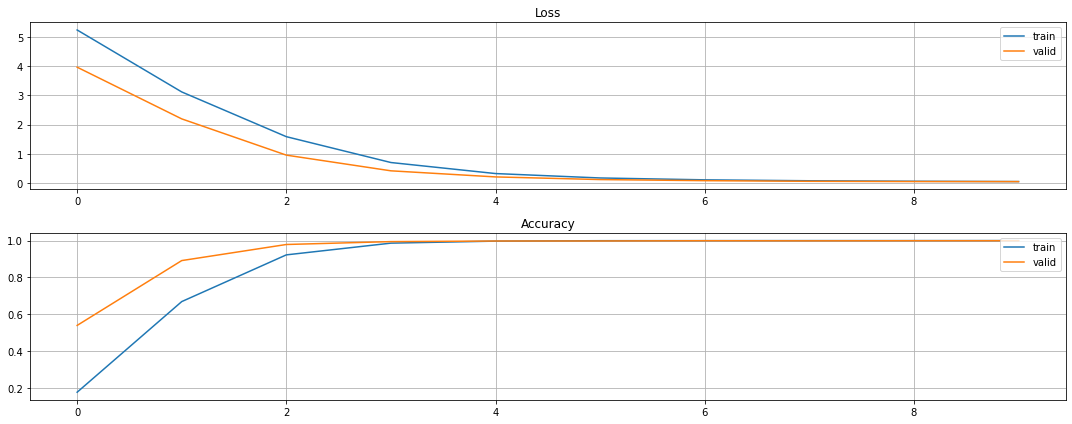

In [10]:
model.plot()

In [11]:
test_proba = model.predict_proba(test_dl)

In [27]:
test_true = test_ds[:][1].numpy()
test_pred = np.argmax(test_proba, axis=1)
acc = sum(test_pred == test_true) / len(test_ds)
print(acc)

0.9188888888888889


In [36]:
train_valid_dl = DataLoader(
    train_valid_ds, 
    batch_size=CONFIG['batch'], 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True, 
    drop_last=True
)

In [43]:
model = ClassificationEngine(
    backbone=XVector(n_mfcc=CONFIG['mfcc'], dropout_p=CONFIG['dropout'])
)
trainer = pl.Trainer(
    gpus=(1 if torch.cuda.is_available() else None), 
    deterministic=True, 
    max_epochs=10, 
    precision=(16 if torch.cuda.is_available() else 32), 
    num_sanity_val_steps=0, 
    fast_dev_run=CONFIG['debug']
)
trainer.fit(model, train_valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type    | Params
-------------------------------------
0 | backbone | XVector | 7.4 M 
-------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.573    Total estimated model params size (MB)


RuntimeError: Unable to find a valid cuDNN algorithm to run convolution

In [38]:
test_proba = model.predict_proba(test_dl)
test_true = test_ds[:][1].numpy()
test_pred = np.argmax(test_proba, axis=1)
acc = sum(test_pred == test_true) / len(test_ds)
print(acc)


0.9253968253968254


In [39]:
xvector = nn.Sequential(*list(model.backbone.children())[:-1])

In [41]:
xvector.to("cuda")
xvector.eval()
emb = []
for batch in tqdm(train_valid_dl):
    x, y = batch
    x = x.to("cuda")
    logits = xvector(x)
    emb.append(logits)
    torch.cuda.empty_cache()

RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 11.00 GiB total capacity; 8.00 GiB already allocated; 0 bytes free; 8.81 GiB reserved in total by PyTorch)